In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

# Model

![../images/master_eq_model.png](../images/master_eq_model.png)

In [2]:
sns.set_palette('colorblind')

# Load the data

# load
correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES",'col',['K16','L16','M16'])

# Rename the columns

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1µM_target',
                   "['K10', 'L10', 'M10']": '0.1µM_target',
                     "['K11', 'L11', 'M11']":'0.01µM_target' ,
                     "['K12', 'L12', 'M12']": '1nM_target',
                    "['K13', 'L13', 'M13']": '0.1nM_target',
                      "['K14', 'L14', 'M14']":'0.01nM_target' ,
                     "['K15', 'L15', 'M15']": '0.1pM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1µM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1µM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01µM_target_std',
                   6: '1µM_FITC_std',
                     7:'1nM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1nM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01nM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1pM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

## New data

In [3]:
targ = pd.read_csv('../results/SHERLOCK/all_targets/pos_targets.csv')
targ.head()

,Unnamed: 0,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,40s,100µM_ToxR,EF1a,...,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.090476,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.211587,0.000000,0.0,0.0,0.0,0.000000,0.526190,...,0.000000,0.0,0.0,0.660476,0.000000,0.506190,0.0,0.0,0.0,0.0
4,4,0.0,0.0,1.891746,0.507302,0.0,0.0,0.0,0.376825,1.000635,...,0.193651,0.0,0.0,1.126190,0.407937,1.189048,0.0,0.0,0.0,0.0


# Define the model

In [30]:
def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,480,97) # number of time points
    
    t = np.linspace(0,500,500) # number of time point to solve 
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        if m.tolist()[2][i] < 1000:
            err.append((obs[i]-m.tolist()[2][i])**2)  
    
    erro = np.sum(err)

    return erro

## Fit the data by adjusting the parameters by hand

In [31]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

In [32]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])


sns.set_context('notebook')
sns.set_palette("tab10")

plt.plot(times,m[2])
plt.errorbar(times,correct[correct.columns[1]],yerr=correct['1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r,3)))
plt.tight_layout()
#plt.xlim(50,480)
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()

NameError: name 'correct' is not defined

## With minimization

In [33]:
targ.columns

Index(['Unnamed: 0', 'PositiveC', '100nM_Trigopus', 'SD', 'Synthetic DNA',
       '10nM_Trigopus', 'IL17', '40s', '100µM_ToxR', 'EF1a', 'DnaJ07',
       'Trigopus', 'NC ', 'DnaJ09', 'DnaJ10_f', 'flaA', 'ToxR_f', '100nM_ToxR',
       'ToxRm1', '10nM_ToxR', 'ToxRm2', '100nM_DnaJ07', '10nM_DnaJ07'],
      dtype='object')

In [34]:
targ.columns

Index(['Unnamed: 0', 'PositiveC', '100nM_Trigopus', 'SD', 'Synthetic DNA',
       '10nM_Trigopus', 'IL17', '40s', '100µM_ToxR', 'EF1a', 'DnaJ07',
       'Trigopus', 'NC ', 'DnaJ09', 'DnaJ10_f', 'flaA', 'ToxR_f', '100nM_ToxR',
       'ToxRm1', '10nM_ToxR', 'ToxRm2', '100nM_DnaJ07', '10nM_DnaJ07'],
      dtype='object')

In [35]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

bnds = [(0.00000001,1000000000),(0.00000001,1000000),(0,3)]
res = optimize.minimize(error, param, args=(list(targ.ToxRm1))
                        ,method='Nelder-Mead',bounds=bnds)#

In [36]:
res.x

array([0.11390562, 0.05152699, 0.01634994])

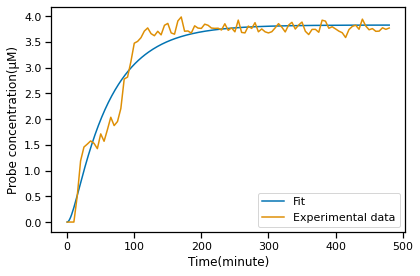

In [37]:
#times = np.linspace(0,480,97)
times = np.linspace(0,480,97*3-1)
times_exp = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                	t_eval=times,dense_output=True)
m = sol.sol(times)

## 
counter = 0
cleaned_m = []
for val in m[2]:
    if counter%3 == 0:
        cleaned_m.append(val)
    counter +=1
    
#r = r2_score(correct[correct.columns[1]],m[2])
r = r2_score(targ.PositiveC,cleaned_m)


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.errorbar(times_exp,targ.ToxRm1,label="Experimental data")#,yerr=correct['0.1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
#plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
plt.tight_layout()
plt.legend()
#plt.xlim(0,50)
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
#plt.savefig("../images/fixed_model.png",dpi=300)
plt.show()

In [38]:
param = [x for x in res.x]
param

[0.11390561850443788, 0.05152698841632133, 0.016349944218939223]

# Plot all the species in the model

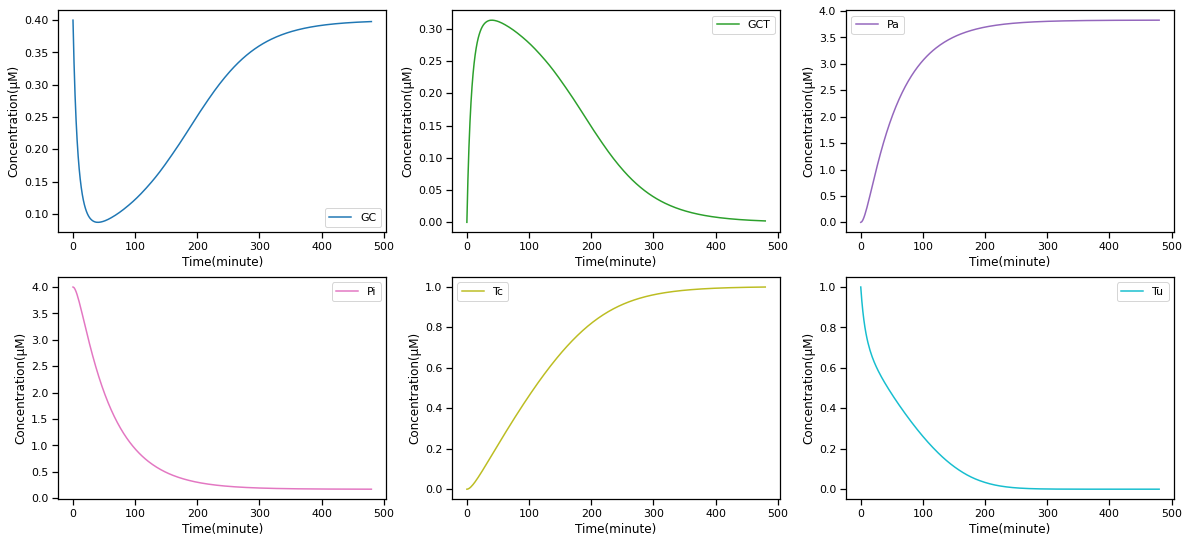

In [39]:
fig,ax = plt.subplots(2,3)
fig.set_size_inches(20,9)

def get_cmap(n, name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(6)

counter=0
name = ["GC",'GCT',"Pa","Pi","Tc","Tu"]
for r in range(2):
    for c in range(3):
        ax[r,c].plot(times,m[counter],label=name[counter],c=cmap(counter))
        ax[r,c].set_xlabel('Time(minute)')
        ax[r,c].set_ylabel('Concentration(µM)')
        ax[r,c].legend()
        ax[r,c].ticklabel_format(useOffset=False)
        #ax[r,c].set_xlim(0,75)
        counter += 1
    
#plt.savefig("../images/SHERLOCK/modeling/all_species.png",dpi=300)
#plt.savefig("all_species.png",dpi=300)
plt.show()

k = []

for i in range(len(m[1])):
    k.append(res.x[1]*m[1][i])
k_s = [x*60 for x in k ] 
times_s = [x*60 for x in times]

plt.plot(times_s,k_s)
plt.ylabel("Unspecific reaction rate(sec-1)")
plt.xlabel('Time(s)')
#plt.savefig('../images/SHERLOCK/modeling/reaction_rate_poc.png',dpi=300)
plt.show()

# Test different target concentration

correct.columns

constants = pd.DataFrame()
times_exp = np.linspace(0,480,97)


for i,j,k in zip([1,3,5],['1µM_target_std','0.1µM_target_std','0.01µM_target_std'],[1,0.1,0.01]):
    z = [GC0,GCT0,Pa0,Pi0,Tc0,k]
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[i]])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    constants[j.strip('std')] = [k1,k2,k3]
    
    r = r2_score(correct[correct.columns[i]],m[2])

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,correct[correct.columns[i]],label="Experimental data",yerr=correct[j])
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    #plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
    #plt.legend()
    plt.show()

constants = constants.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')



constants

times = np.linspace(0,480,97)

d = 1

z = [GC0,GCT0,Pa0,Pi0,Tc0,d]

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants[str(d)+'µM_target_']]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)

    
k = [] # list that will contain all the value of k3

'''
K3 depends on the concentration of Pi to compute it's value
I multiply each value of Pi by the value obtained for k3
by the minimization
m[3] is the solution of the system of ODE for Pi
constants is the dataframe where I stored all the values of k
k_s is a list of value of k but in seconds-1 (min-1 * 60)
I then plot the value of k3 as a function of the concentration of inactive probe
'''

for i in range(len(m[3])): 
    k.append(constants.iloc[1].values[0]*m[1][i])
    
k_s = [x*60 for x in k ] 
times_s = [x*60 for x in times]

plt.plot(times_s,k_s)
plt.ylabel("Unspecific reaction rate(sec-1)")
plt.xlabel('Time(s)')

#plt.savefig('../images/SHERLOCK/modeling/reaction_rate_poc.png',dpi=300)
plt.show()

constants

def constant(t,k,p,z):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 1,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]
 
    sol = solve_ivp(system,t_span =[0, times.max()], y0= [GC0,GCT0,Pa0,Pi0,Tc0,z] , args =([constants[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(constants.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    #plt.show()

#const('1nM_target_',1)

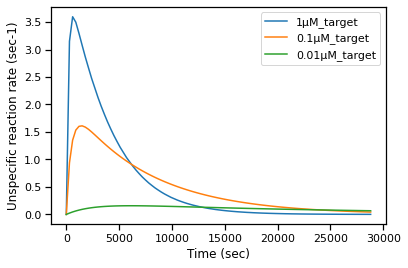

In [97]:
for t,p,z in zip(constants.columns,range(3),[1,0.1,0.01]):
    constant(t,3,p,z)

legend = [x.strip('_') for x in constants.columns]
plt.legend(legend)

#plt.yscale('log')
#plt.xscale('log')
plt.savefig('../images/SHERLOCK/modeling/catalytic_rates.png',dpi=300)
plt.show()

# Fit individual experimental curves

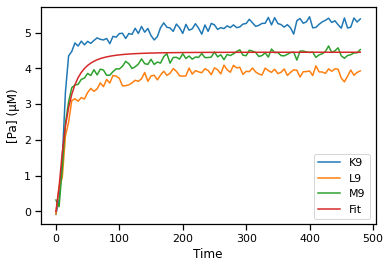

In [14]:
df = px.excelreader('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES")
for i,j in zip(['K9','L9','M9'],['K16','L16','M16']):
    df[i] = df[i] - df[j]

df[['K9','L9','M9','Time']].plot(x='Time')
plt.plot(times,m[2],label="Fit")
plt.ylabel("[Pa] (µM)")
plt.legend()
plt.show()

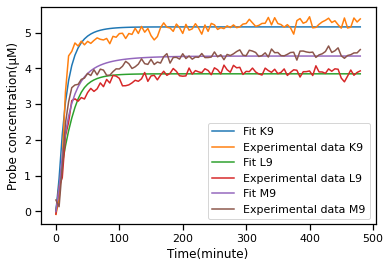

In [15]:
const = pd.DataFrame()

for i,j in zip(['K9','L9','M9'],[5.5,Pi0,Pi0]):
    z = [GC0,GCT0,Pa0,j,Tc0,Tu0]
    res = optimize.minimize(error, param, args=(list(df[i])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    const[i] = [k1,k2,k3]
    
    r = r2_score(df[i],m[2])

    plt.plot(times,m[2],label="Fit "+ str(i))
    plt.plot(times,df[i],label="Experimental data "+str(i))
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.legend()
    #plt.show()

const = const.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')

#plt.savefig('../images/SHERLOCK/modeling/fitting_individual_curves.png',dpi=300)

In [16]:
const

,K9,L9,M9
k1,0.116694,7.950303,0.049948
k3,0.523984,0.088840,1.191031
k4,0.188385,0.045989,0.353594


In [44]:
def constante(t,k,p,df):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 1,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]
 
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([df[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(df.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    return k_s

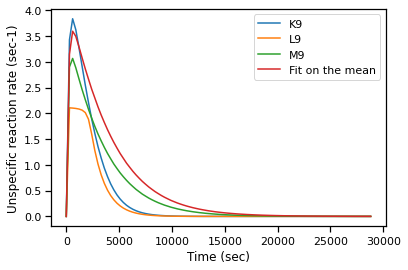

In [18]:
z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
ks = []
for i,j in zip(const.columns,range(3)):
    ks.append(constante(i,3,j))
    
legend = [x for x in const.columns]
legend.append("Fit on the mean")

constant(constants.columns[0],3,0,1)

plt.legend(legend)

#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_curves.png',dpi=300)
plt.show()

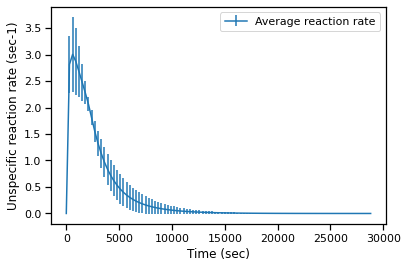

In [30]:
k_m = [np.mean([ks[0][i],ks[1][i],ks[2][i]]) for i in range(len(ks[0]))]
k_sd = [np.std([ks[0][i],ks[1][i],ks[2][i]]) for i in range(len(ks[0]))]

plt.errorbar(times_s,k_m,yerr=k_sd)
plt.xlabel("Time (sec)")
plt.ylabel("Unspecific reaction rate (sec-1)")
plt.legend(["Average reaction rate"])

#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_mean.png',dpi=300)
plt.show()

## Fitting K1

for t,p,z in zip(constants.columns,range(3),[1,0.1,0.01]):
    constant(t,1,p,z)

legend = [x.strip('_') for x in constants.columns]
plt.legend(legend)

#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('../images/SHERLOCK/modeling/binding_rates.png',dpi=300)
plt.show()

k_1 = []
for i,j in zip(const.columns,range(3)):
    print(i,j)
    k_1.append(constante(i,1,j))
    
legend = [x for x in const.columns]
legend.append("Fit on the mean")

constant(constants.columns[0],1,0,1)

plt.legend(legend)

#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_curves.png',dpi=300)
plt.show()

k_m = [np.mean([k_1[0][i],k_1[1][i],k_1[2][i]]) for i in range(len(k_1[0]))]
k_sd = [np.std([k_1[0][i],k_1[1][i],k_1[2][i]]) for i in range(len(k_1[0]))]

plt.errorbar(times_s,k_m,yerr=k_sd)
plt.xlabel("Time (sec)")
plt.ylabel("Cas_binding rate (sec-1)")
plt.legend(["Average reaction rate"])

#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_mean.png',dpi=300)
plt.show()

# Fitting all the targets

In [40]:
x = [x for x in targ.columns if "Unnamed" not in x and "_sd" not in x and 'NC' not in x and '40s' not in x]

#x.append('ToxRm1')
x

['PositiveC',
 '100nM_Trigopus',
 'SD',
 'Synthetic DNA',
 '10nM_Trigopus',
 'IL17',
 '100µM_ToxR',
 'EF1a',
 'DnaJ07',
 'Trigopus',
 'DnaJ09',
 'DnaJ10_f',
 'flaA',
 'ToxR_f',
 '100nM_ToxR',
 'ToxRm1',
 '10nM_ToxR',
 'ToxRm2',
 '100nM_DnaJ07',
 '10nM_DnaJ07']

In [5]:
Time = [x*5 for x in range(len(targ.PositiveC))]
#Time

In [6]:
t = targ[x]
t.insert(0,'Time', Time)
t

,Time,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,100µM_ToxR,EF1a,DnaJ07,...,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10,0.000000,0.000000,0.090476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,15,0.000000,0.000000,1.211587,0.000000,0.000000,0.000000,0.000000,0.526190,0.000000,...,0.000000,0.000000,0.000000,0.660476,0.000000,0.506190,0.000000,0.000000,0.000000,0.000000
4,20,0.000000,0.000000,1.891746,0.507302,0.000000,0.000000,0.376825,1.000635,0.000000,...,0.193651,0.000000,0.000000,1.126190,0.407937,1.189048,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,460,3.287937,3.384444,3.605714,4.728571,2.253651,4.076032,3.141587,3.657619,2.928095,...,3.317143,0.750794,1.762540,2.974762,3.433175,3.706508,0.590635,3.334603,3.660476,0.881587
93,465,3.318413,3.360635,3.717778,4.766190,2.533968,4.216825,3.388413,3.650317,3.000000,...,3.477937,0.854921,1.776984,3.080635,3.471587,3.710317,0.716508,3.484921,3.781429,0.960794
94,470,3.386190,3.363175,3.796190,4.682063,2.515873,4.196508,3.264603,3.680159,2.973810,...,3.368889,0.816032,1.732063,3.085714,3.476984,3.774921,0.679365,3.590794,3.716825,1.012381
95,475,3.415873,3.493810,3.826984,4.742857,2.532857,4.264127,3.332063,3.625397,2.966667,...,3.397778,0.765873,1.925397,3.038889,3.580159,3.744921,0.745556,3.536032,3.778889,1.093492


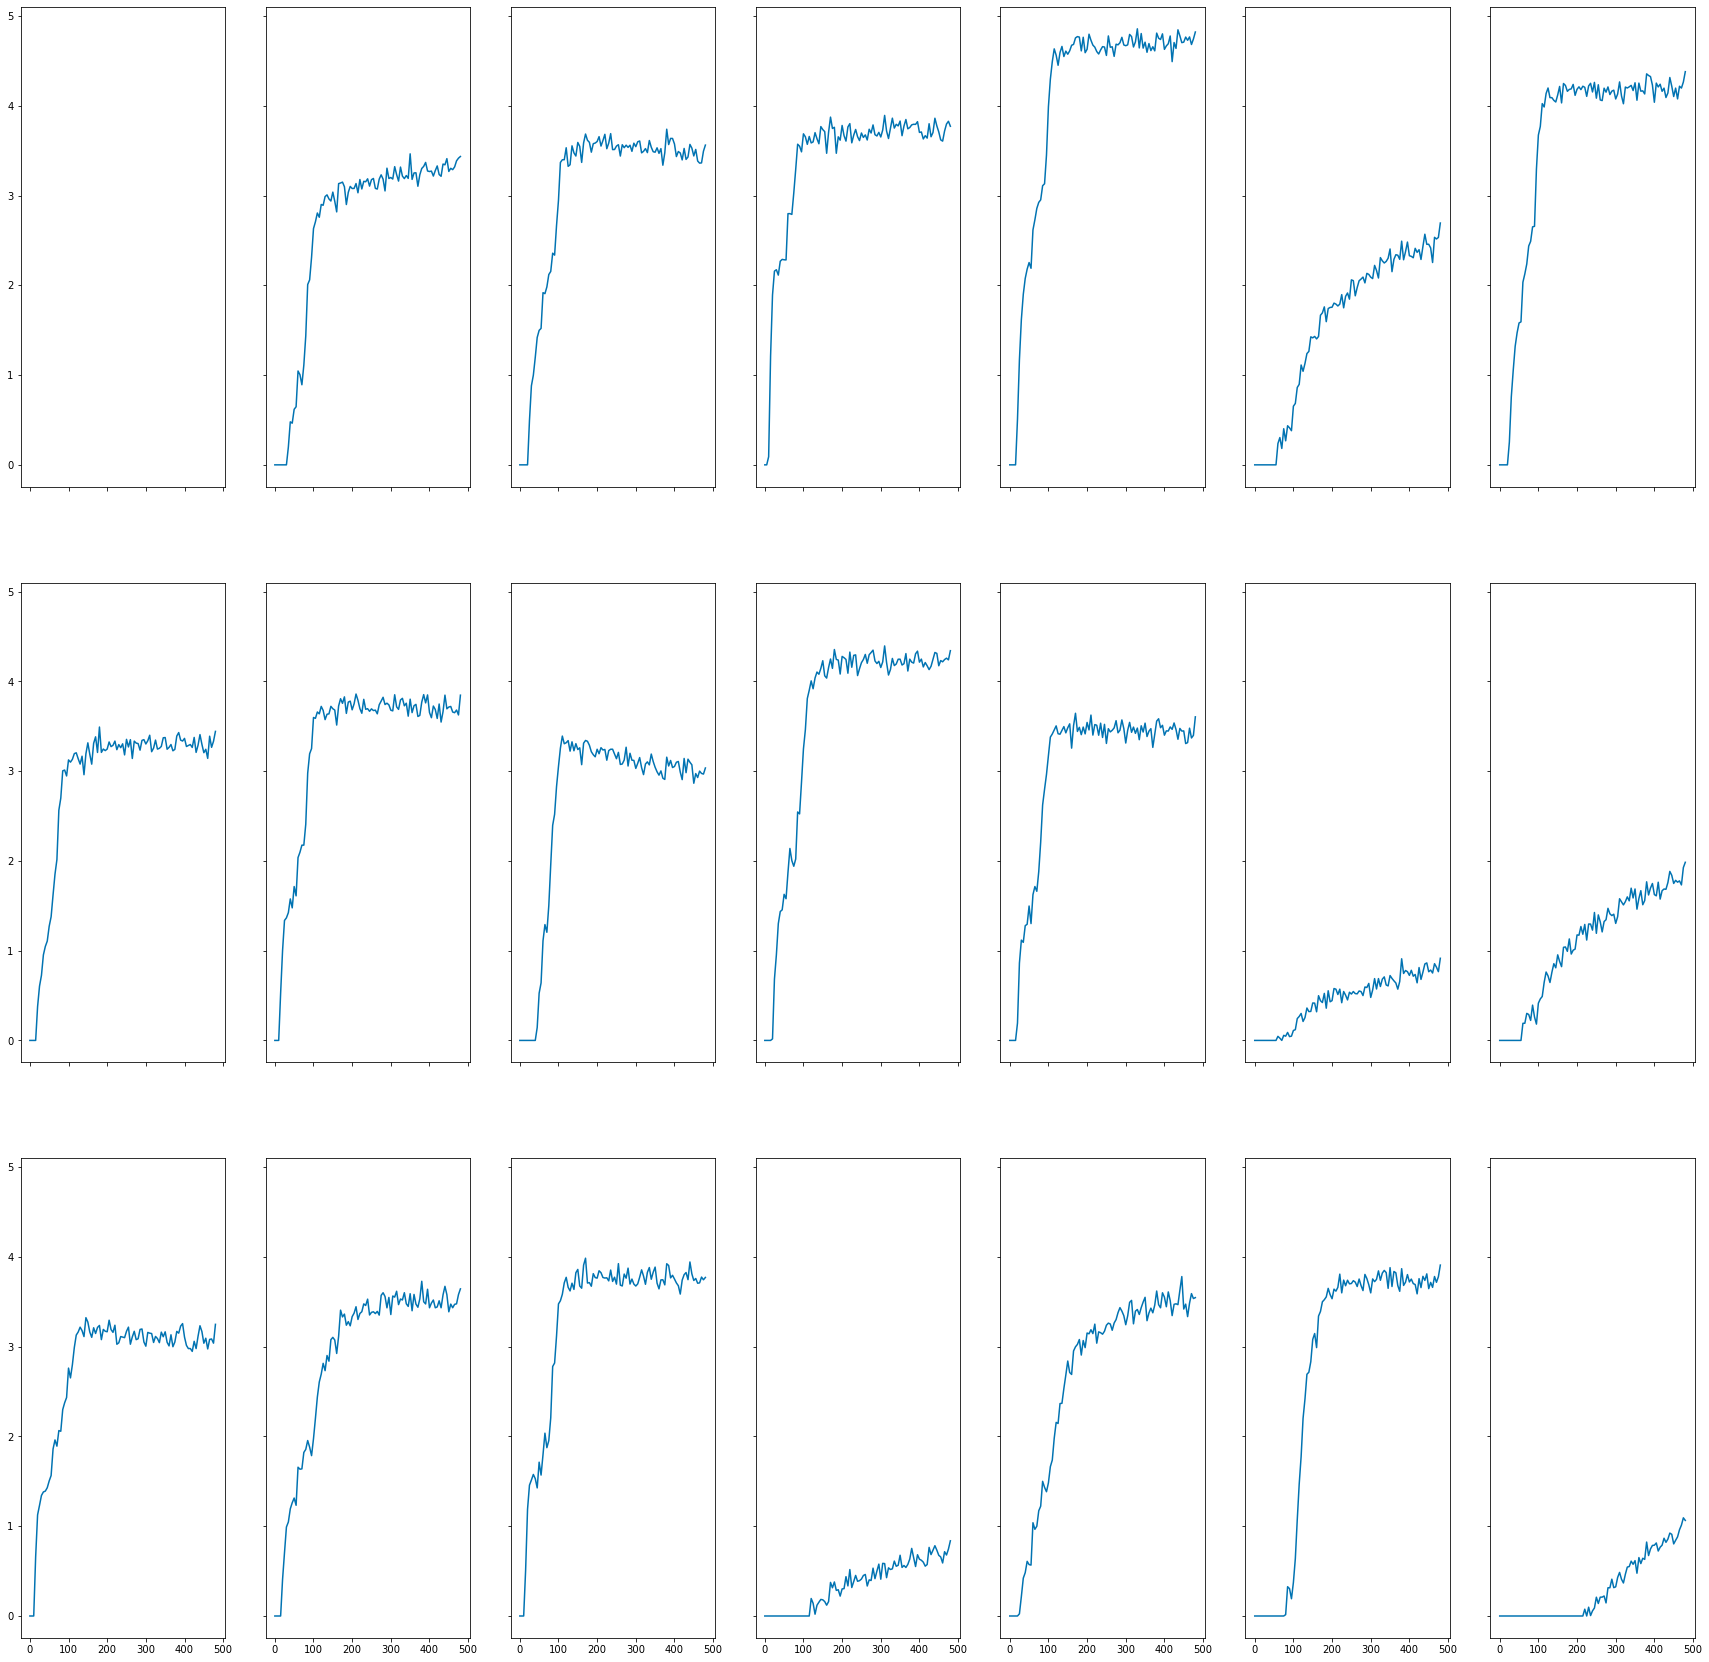

In [7]:
px.plot_raw_data(t,3,7)

Trying sequence PositiveC...


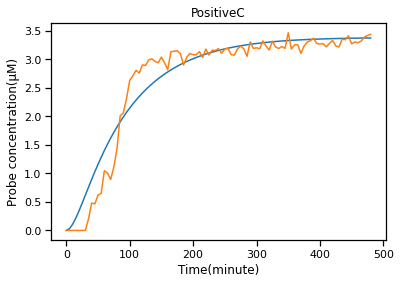

Done for PositiveC
---------------------------------------------------------------------
Trying sequence 100nM_Trigopus...
100nM_Trigopus


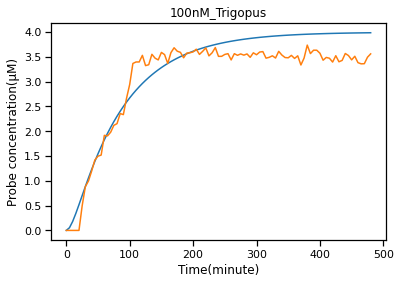

Done for 100nM_Trigopus
---------------------------------------------------------------------
Trying sequence SD...


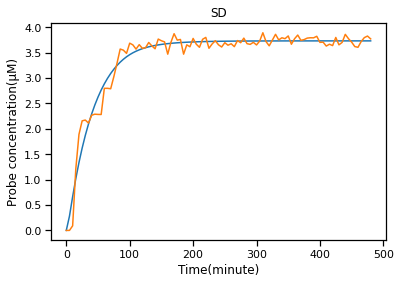

Done for SD
---------------------------------------------------------------------
Trying sequence Synthetic DNA...


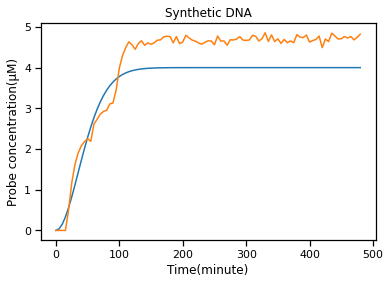

Done for Synthetic DNA
---------------------------------------------------------------------
Trying sequence 10nM_Trigopus...
10nM_Trigopus


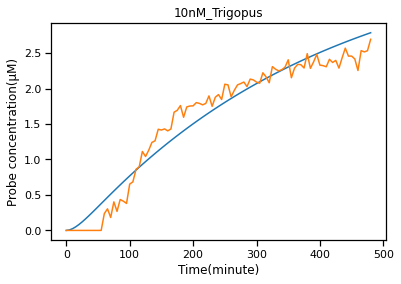

Done for 10nM_Trigopus
---------------------------------------------------------------------
Trying sequence IL17...


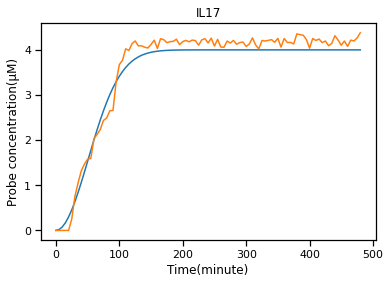

Done for IL17
---------------------------------------------------------------------
Trying sequence 100µM_ToxR...
100µM_ToxR


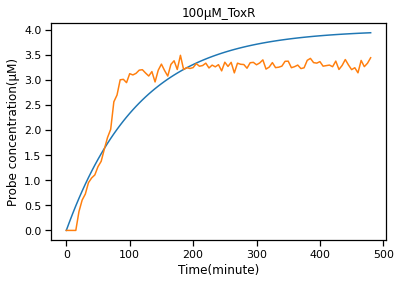

Done for 100µM_ToxR
---------------------------------------------------------------------
Trying sequence EF1a...


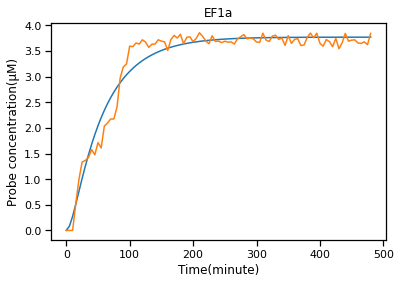

Done for EF1a
---------------------------------------------------------------------
Trying sequence DnaJ07...


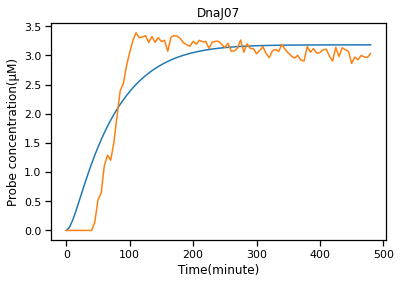

Done for DnaJ07
---------------------------------------------------------------------
Trying sequence Trigopus...


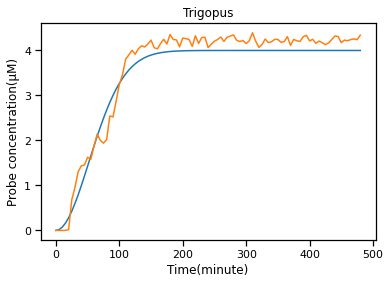

Done for Trigopus
---------------------------------------------------------------------
Trying sequence DnaJ09...


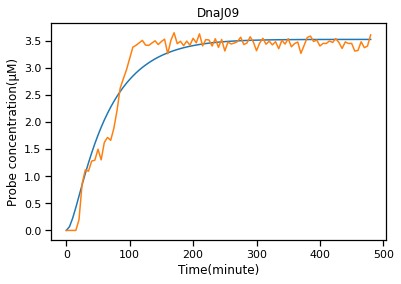

Done for DnaJ09
---------------------------------------------------------------------
Trying sequence DnaJ10_f...


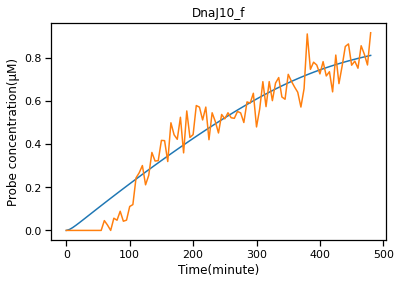

Done for DnaJ10_f
---------------------------------------------------------------------
Trying sequence flaA...


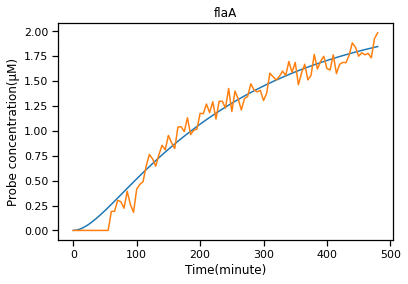

Done for flaA
---------------------------------------------------------------------
Trying sequence ToxR_f...


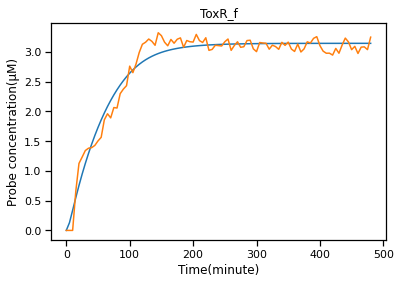

Done for ToxR_f
---------------------------------------------------------------------
Trying sequence 100nM_ToxR...
100nM_ToxR


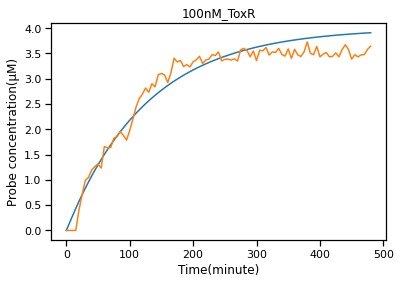

Done for 100nM_ToxR
---------------------------------------------------------------------
Trying sequence ToxRm1...


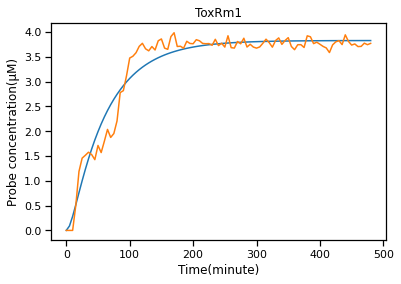

Done for ToxRm1
---------------------------------------------------------------------
Trying sequence 10nM_ToxR...
10nM_ToxR


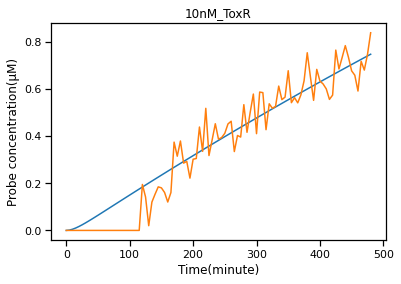

Done for 10nM_ToxR
---------------------------------------------------------------------
Trying sequence ToxRm2...


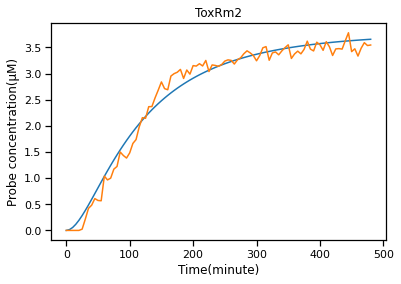

Done for ToxRm2
---------------------------------------------------------------------
Trying sequence 100nM_DnaJ07...
100nM_DnaJ07


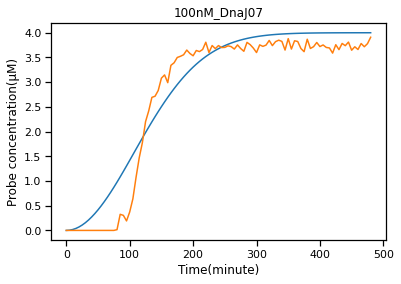

Done for 100nM_DnaJ07
---------------------------------------------------------------------
Trying sequence 10nM_DnaJ07...
10nM_DnaJ07


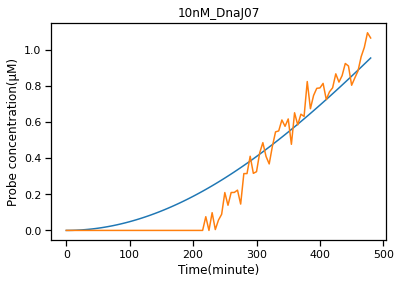

Done for 10nM_DnaJ07
---------------------------------------------------------------------


In [121]:
constants_t = pd.DataFrame()
times_exp = np.linspace(0,480,97)

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
T = [0.1,0.01,100]
for i in x :
    print('Trying sequence ' +str(i)+'...')
    if '100nM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,0.1]
        print(i)
    elif '10nM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,0.01]
        print(i)
    elif '100µM' in i:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,100]
        print(i)
    else:
        z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
        
    #'''
    res = optimize.minimize(error, param , args=(list(targ[i])),method='Nelder-Mead',bounds=bnds)
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    r = r2_score(targ[i],m[2])
    
    constants_t[i] = [k1,k2,k3,r]
    
    

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,targ[i],label="Experimental data")
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.title(i)
    #plt.legend()
    plt.show()
    #'''
    print('Done for ' + str(i))
    print('---------------------------------------------------------------------')

constants_t = constants_t.rename({0: 'k1', 1: 'k3',2:'k4',3:'r2'}, axis='index')

In [122]:
constants_t

#constants_t.to_csv('../images/SHERLOCK/modeling/constants.csv')

,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,100µM_ToxR,EF1a,DnaJ07,Trigopus,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
k1,0.038747,0.271100,0.564478,0.008734,0.146689,0.000147,0.127989,0.083572,0.076040,0.000921,0.075437,0.207927,0.014051,0.368588,8.179663,0.113906,1.830781e-01,0.016854,0.000129,0.000549
k3,0.044919,0.123543,0.060790,0.233294,0.257666,6.582926,0.021944,0.063233,0.042565,1.003065,0.055589,0.001552,0.012086,0.033999,0.078963,0.051527,4.431469e-02,0.047526,16.960118,1.116052
k4,0.024067,0.000000,0.022486,0.000000,0.000000,0.000000,0.022307,0.022070,0.026810,0.001297,0.026191,0.005958,0.015743,0.022036,0.000000,0.016350,1.747506e-07,0.016652,0.000000,0.000005
r2,0.938162,0.879840,0.960750,0.747005,0.947886,0.968605,0.751276,0.958262,0.856145,0.954821,0.947609,0.928368,0.974834,0.962290,0.941996,0.945942,9.123002e-01,0.979797,0.933608,0.915575


In [10]:
constants_t = pd.read_csv('../images/SHERLOCK/modeling/constants.csv')
constants_t

,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,100µM_ToxR,EF1a,DnaJ07,Trigopus,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
k1,0.855696,2.004296,2.124811,2.317858,1.998569,2.127937,1.035243,2.138390,2.140946,2.117820,1.981541,0.995954,0.012897,2.142104,1.948295,2.139315,2.117112,1.017019,1.815833,0.815960
k3,0.017071,0.759992,0.028382,0.043064,1.016985,0.031471,0.016407,0.030148,0.019821,0.030026,0.024693,0.111303,0.477802,0.024225,0.761306,0.023212,0.066294,0.013559,1.003419,0.034224
k4,0.012626,0.059296,-0.064829,-0.104435,0.012666,0.010600,1.015760,0.016487,0.016109,0.009401,0.016283,1.016026,1.059225,0.019995,0.066908,-0.003347,0.003340,0.008484,0.098678,-0.000811


In [124]:
# Filter bad fits
c = constants_t.loc[:,constants_t.loc['r2'] > 0.85]

c

,PositiveC,100nM_Trigopus,SD,10nM_Trigopus,IL17,EF1a,DnaJ07,Trigopus,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
k1,0.038747,0.271100,0.564478,0.146689,0.000147,0.083572,0.076040,0.000921,0.075437,0.207927,0.014051,0.368588,8.179663,0.113906,1.830781e-01,0.016854,0.000129,0.000549
k3,0.044919,0.123543,0.060790,0.257666,6.582926,0.063233,0.042565,1.003065,0.055589,0.001552,0.012086,0.033999,0.078963,0.051527,4.431469e-02,0.047526,16.960118,1.116052
k4,0.024067,0.000000,0.022486,0.000000,0.000000,0.022070,0.026810,0.001297,0.026191,0.005958,0.015743,0.022036,0.000000,0.016350,1.747506e-07,0.016652,0.000000,0.000005
r2,0.938162,0.879840,0.960750,0.947886,0.968605,0.958262,0.856145,0.954821,0.947609,0.928368,0.974834,0.962290,0.941996,0.945942,9.123002e-01,0.979797,0.933608,0.915575


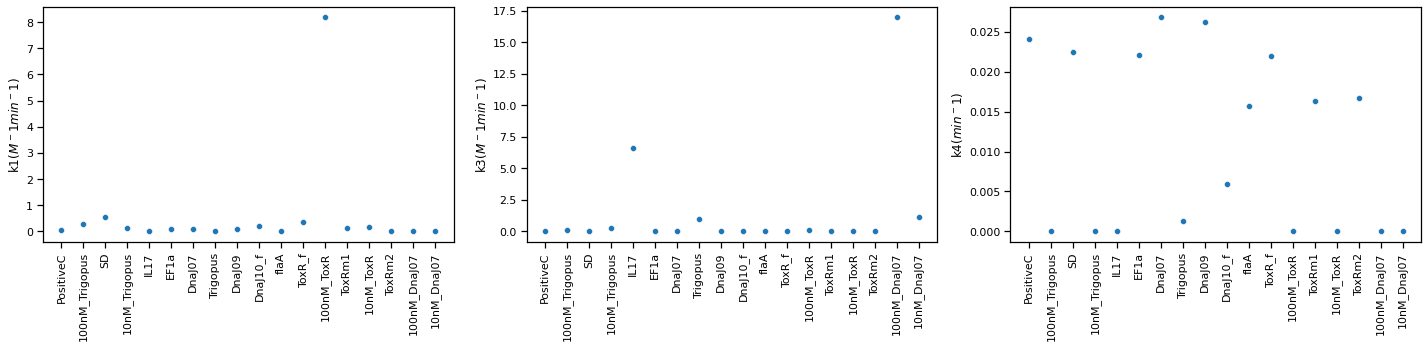

In [126]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

counter = 0

for i in c.index:
    if i == c.index[-1]:
        break
    n = [x for x in c.loc[i].index]

    sns.scatterplot([x for x in range(len(c.loc[i]))],c.loc[i],ax =ax[counter])
    
    ax[counter].set_xticks([x for x in range(len(c.loc[i]))])

    ax[counter].set_xticklabels(n,rotation=90)
    
    if i != 'k4':
        ax[counter].set_ylabel(str(i)+'($M^-1min^-1$)')
    else:
        ax[counter].set_ylabel(str(i)+'($min^-1$)')
    counter+=1

plt.tight_layout()
#plt.savefig('../images/SHERLOCK/modeling/distribution_constants.png',dpi=300)
plt.show()
    

In [127]:
# get the ToxR from constants dataframe
tox = [x for x in constants_t.columns if 'ToxRm' in x or 'ToxR_f' in x] 
val = constants_t[tox]
# add to  new dataframe the other mutation (0 value for all constants)
pos = [3,4,5,6]
name = [x for x in allt.columns if 'ToxRm' in x and x not in tox and 'sd' not in x]
name.sort(key=len)
values = [0,0,0,0]

for i in range(len(pos)):
    val.insert(pos[i], name[i], values)
    
val

,ToxR_f,ToxRm1,ToxRm2,ToxRm4,ToxRm6,ToxRm8,ToxRm10
k1,0.368588,0.113906,0.016854,0,0,0,0
k3,0.033999,0.051527,0.047526,0,0,0,0
k4,0.022036,0.016350,0.016652,0,0,0,0
r2,0.962290,0.945942,0.979797,0,0,0,0


In [128]:
[x for x in val.loc[i].index ]

KeyError: 3

In [130]:
sns.set_context('talk')

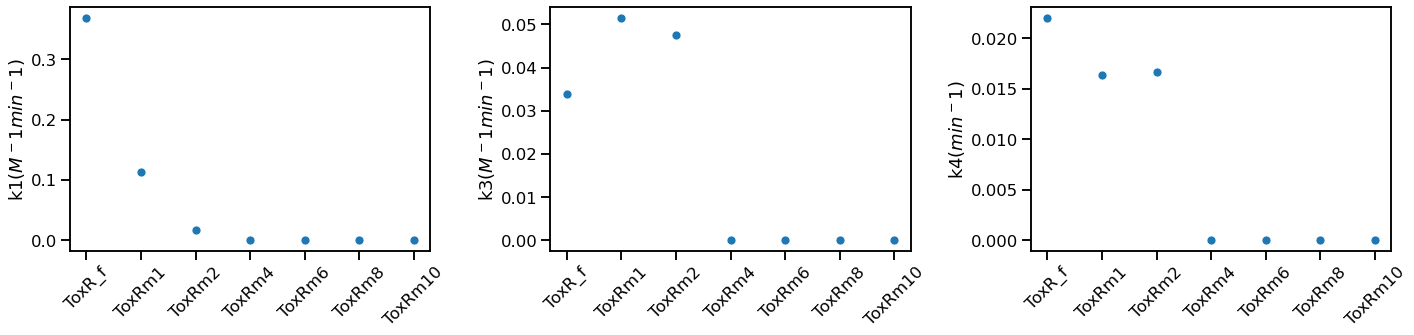

In [132]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

counter = 0
for i in val.index:
    if i == 'r2':
        break
    n = [x for x in val.loc[i].index ]

    sns.scatterplot([x for x in range(len(val.loc[i]))],val.loc[i],ax=ax[counter])
    ax[counter].set_xticks([x for x in range(len(val.loc[i]))])
    ax[counter].set_xticklabels(n,rotation=45)
    #ax[counter].set_ylim(0.0001,10)
    #ax[counter].set_yscale('log')
    
    if i != 'k4':
        ax[counter].set_ylabel(str(i)+'($M^-1min^-1$)')
    else:
        ax[counter].set_ylabel(str(i)+'($min^-1$)')
       
    counter +=1    

plt.tight_layout()
#plt.savefig('../images/SHERLOCK/modeling/mutation_const.png',dpi=300)
plt.show()

for i in constants_t.columns:
    m = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants_t[i]]),
                            t_eval=times,dense_output=True)
    m = m.sol(times)

    plt.plot(m[1])


from matplotlib.pyplot import figure

figure(figsize=(8, 6))

for i,j in zip(constants_t.columns,range(len(constants_t.columns))):
    constante(i,3,j,constants_t)
    
legend = [x for x in constants_t.columns]


plt.legend(legend)

#plt.savefig('../images/SHERLOCK/modeling/association_rates_all_targets_2.png',dpi=300)
plt.show()

constants_t

# Fitting with sd

In [23]:
al = px.excelreader('../results/SHERLOCK/all_targets/220920_sherlock_v2.xlsx'
               ,75,"YES")

In [50]:
name = pd.read_csv('../results/SHERLOCK/all_targets/plan_de_plaque_3.txt',sep = "\t", header=None)
names = list(name[2].values)

names.extend(['Time'])
print(len(names))

68


In [49]:
for i in range(len(al.columns)):
    al.rename(columns={al.columns[i]:names[i]},inplace=True)
    
len(al.columns)

68

In [27]:
al['PositiveC_1']

0     4.334897
1     4.695015
2     4.941935
3     4.873314
4     4.914370
        ...   
92    9.230792
93    9.078886
94    9.133431
95    9.150440
96    9.198240
Name: PositiveC_1, Length: 97, dtype: float64

In [28]:
for i in al.columns:
    al[i] = al[i] - al['Average']
    al[al < 0] = 0
al

,PositiveC_1,PositiveC_2,PositiveC_3,ToxRm10_1,ToxRm10_2,ToxRm10_3,SD_1,SD_2,SD_3,Synthetic DNA_1,...,ToxRm4_2,ToxRm4_3,ToxRm6_1,ToxRm6_2,ToxRm6_3,ToxRm8_1,ToxRm8_2,ToxRm8_3,Average,Time
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.435875,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.735484,0.829032,1.536070,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,0.000000,0.112317,0.000000,0.0,0.0,0.0,1.282405,1.425806,2.405279,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2.654936,3.344086,3.513001,0.0,0.0,0.0,2.689247,3.414174,4.704790,4.267253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0
93,2.755034,3.486413,3.966764,0.0,0.0,0.0,2.620430,3.534506,4.974096,4.394330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0
94,2.797361,3.545748,3.660997,0.0,0.0,0.0,2.742522,3.516129,5.117302,4.590616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,470.0
95,2.636755,3.428250,3.922972,0.0,0.0,0.0,2.652590,3.617107,5.137928,4.355230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475.0


Trying sequence PositiveC_1...


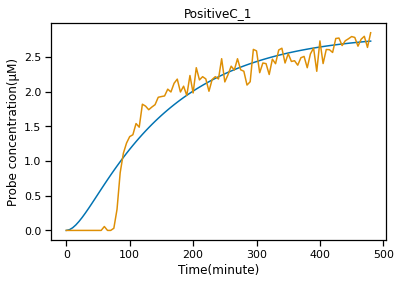

Done for PositiveC_1
---------------------------------------------------------------------
Trying sequence PositiveC_2...


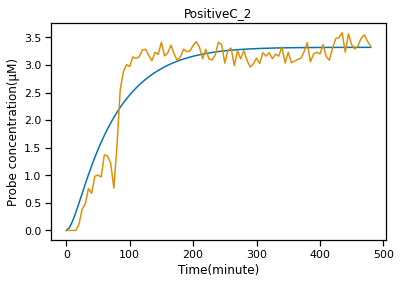

Done for PositiveC_2
---------------------------------------------------------------------
Trying sequence PositiveC_3...


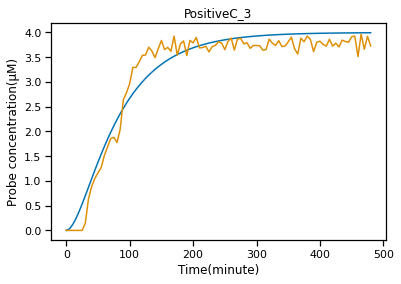

Done for PositiveC_3
---------------------------------------------------------------------
Trying sequence SD_1...


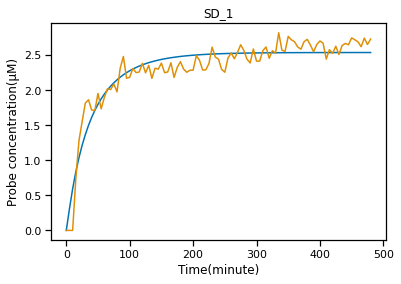

Done for SD_1
---------------------------------------------------------------------
Trying sequence SD_2...


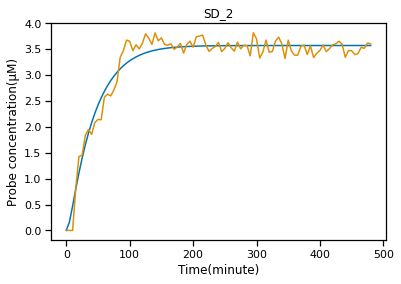

Done for SD_2
---------------------------------------------------------------------
Trying sequence SD_3...


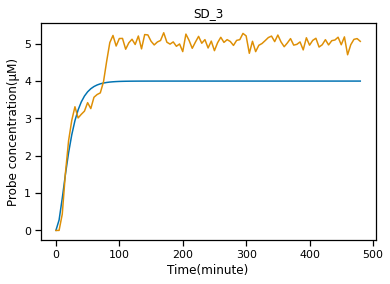

Done for SD_3
---------------------------------------------------------------------
Trying sequence Synthetic DNA_1...


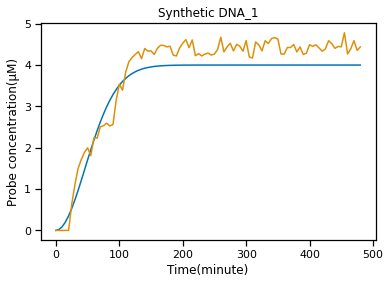

Done for Synthetic DNA_1
---------------------------------------------------------------------
Trying sequence Synthetic DNA_2...


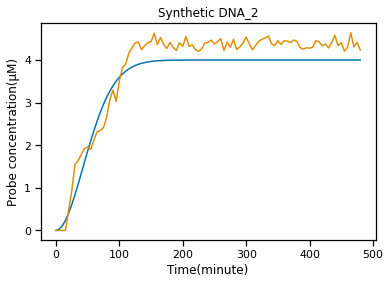

Done for Synthetic DNA_2
---------------------------------------------------------------------
Trying sequence Synthetic DNA_3...


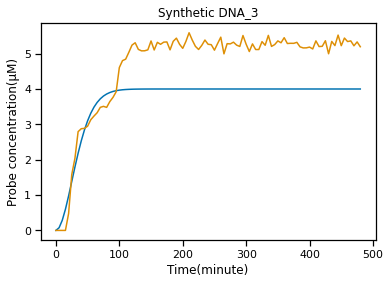

Done for Synthetic DNA_3
---------------------------------------------------------------------
Trying sequence IL17_1...


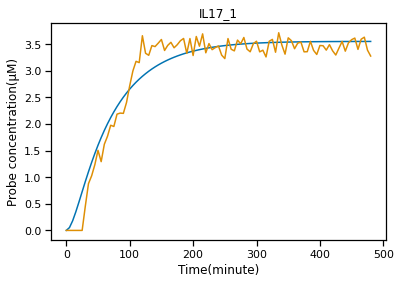

Done for IL17_1
---------------------------------------------------------------------
Trying sequence IL17_2...


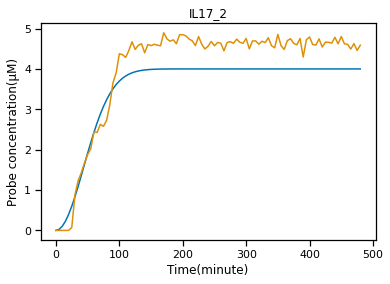

Done for IL17_2
---------------------------------------------------------------------
Trying sequence IL17_3...


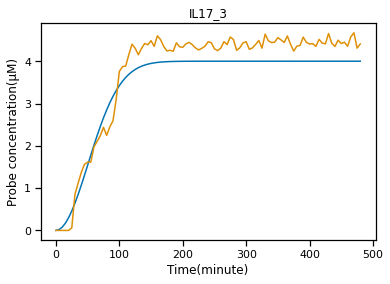

Done for IL17_3
---------------------------------------------------------------------
Trying sequence EF1a_1...


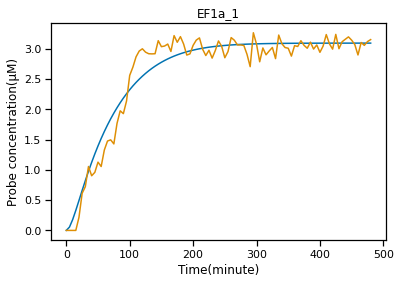

Done for EF1a_1
---------------------------------------------------------------------
Trying sequence EF1a_2...


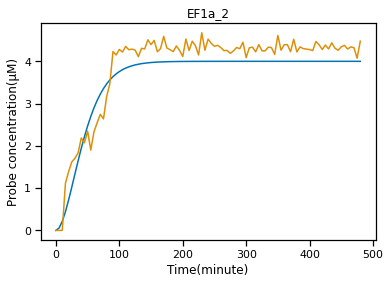

Done for EF1a_2
---------------------------------------------------------------------
Trying sequence EF1a_3...


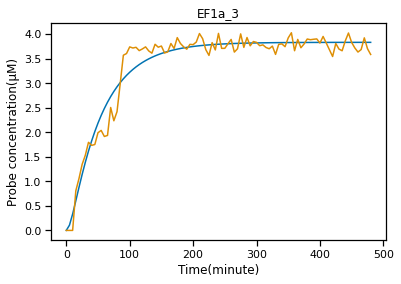

Done for EF1a_3
---------------------------------------------------------------------
Trying sequence DnaJ07_1...


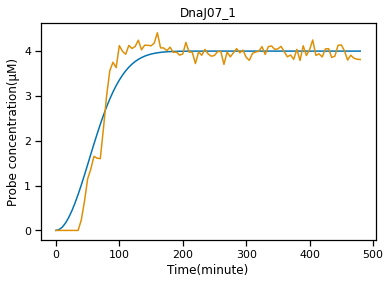

Done for DnaJ07_1
---------------------------------------------------------------------
Trying sequence DnaJ07_2...


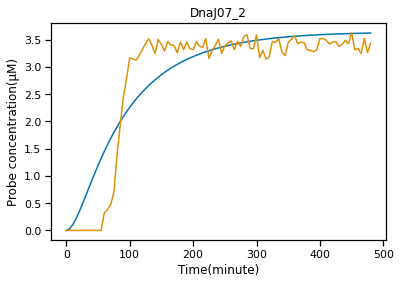

Done for DnaJ07_2
---------------------------------------------------------------------
Trying sequence DnaJ07_3...


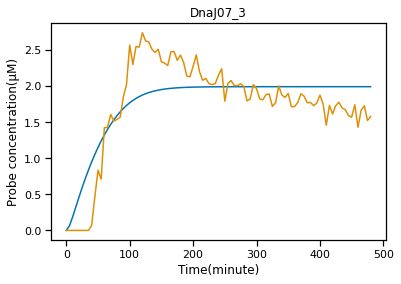

Done for DnaJ07_3
---------------------------------------------------------------------
Trying sequence Trigopus_1...


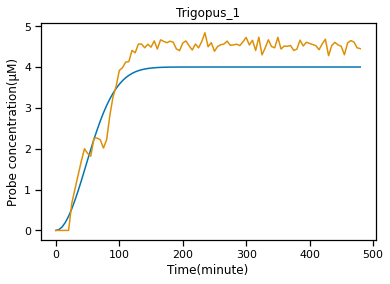

Done for Trigopus_1
---------------------------------------------------------------------
Trying sequence Trigopus_2...


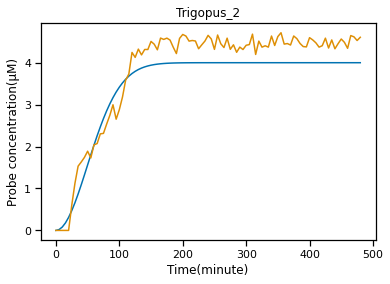

Done for Trigopus_2
---------------------------------------------------------------------
Trying sequence Trigopus_3...


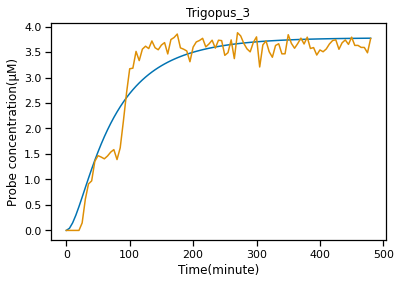

Done for Trigopus_3
---------------------------------------------------------------------
Trying sequence DnaJ09_1...


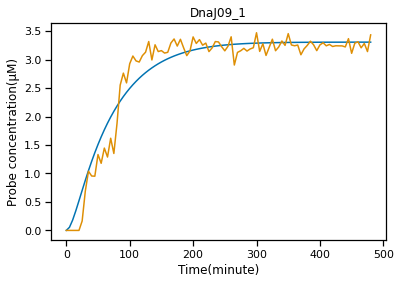

Done for DnaJ09_1
---------------------------------------------------------------------
Trying sequence DnaJ09_2...


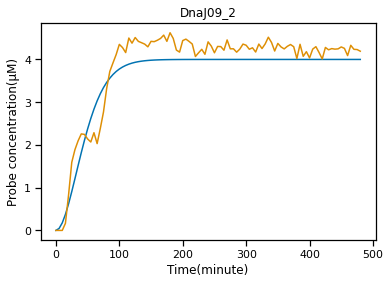

Done for DnaJ09_2
---------------------------------------------------------------------
Trying sequence DnaJ09_3...


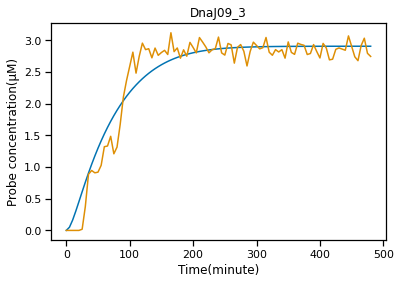

Done for DnaJ09_3
---------------------------------------------------------------------
Trying sequence DnaJ10_2...


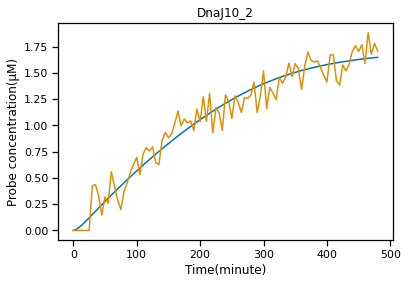

Done for DnaJ10_2
---------------------------------------------------------------------
Trying sequence DnaJ10_3...


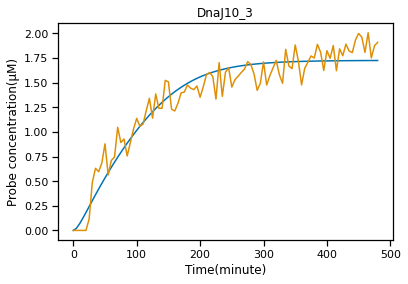

Done for DnaJ10_3
---------------------------------------------------------------------
Trying sequence flaA_1...


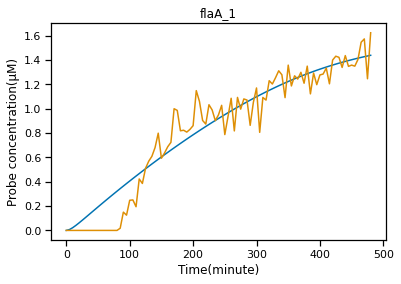

Done for flaA_1
---------------------------------------------------------------------
Trying sequence flaA_2...


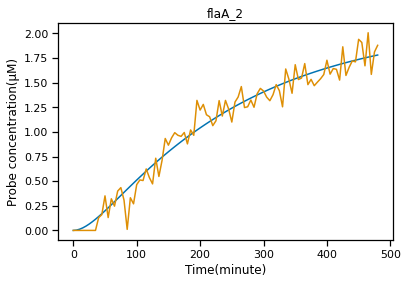

Done for flaA_2
---------------------------------------------------------------------
Trying sequence flaA_3...


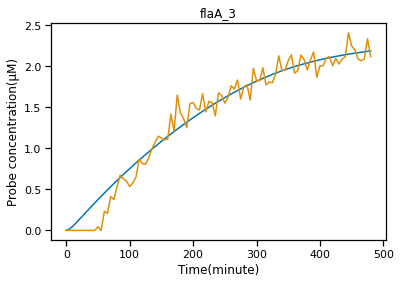

Done for flaA_3
---------------------------------------------------------------------
Trying sequence ToxR_1...


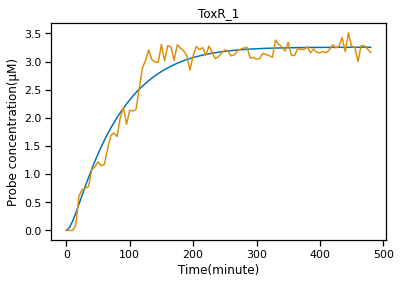

Done for ToxR_1
---------------------------------------------------------------------
Trying sequence ToxR_2...


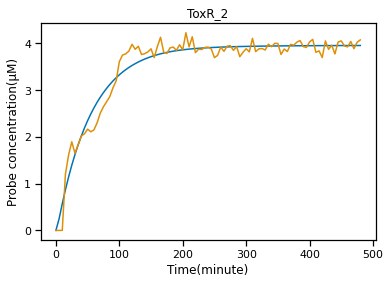

Done for ToxR_2
---------------------------------------------------------------------
Trying sequence ToxR_3...


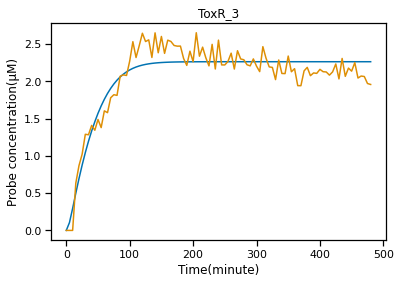

Done for ToxR_3
---------------------------------------------------------------------
Trying sequence ToxRm1_1...


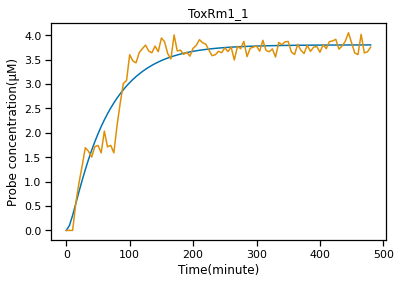

Done for ToxRm1_1
---------------------------------------------------------------------
Trying sequence ToxRm1_2...


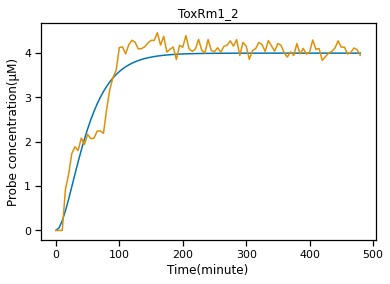

Done for ToxRm1_2
---------------------------------------------------------------------
Trying sequence ToxRm1_3...


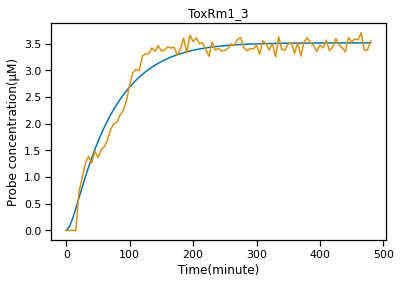

Done for ToxRm1_3
---------------------------------------------------------------------
Trying sequence ToxRm2_1...


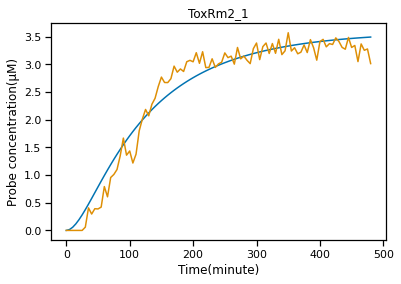

Done for ToxRm2_1
---------------------------------------------------------------------
Trying sequence ToxRm2_2...


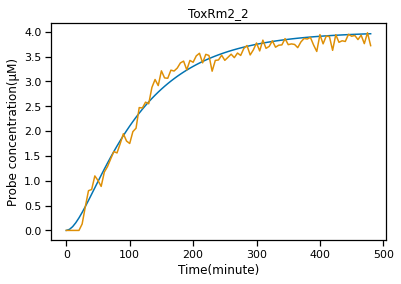

Done for ToxRm2_2
---------------------------------------------------------------------
Trying sequence ToxRm2_3...


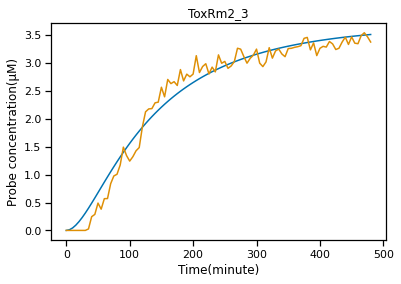

Done for ToxRm2_3
---------------------------------------------------------------------
Trying sequence Time...


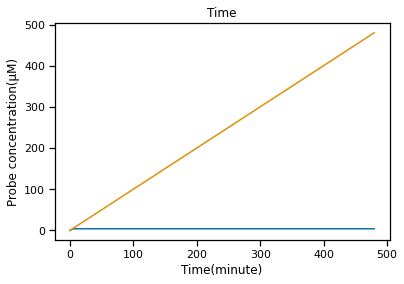

Done for Time
---------------------------------------------------------------------


In [41]:
constants_a = pd.DataFrame()
times_exp = np.linspace(0,480,97)

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
x = [x for x in al.columns if np.max(al[x]) > 1]

for i in x:
    print('Trying sequence ' +str(i)+'...')

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
        
    #'''
    res = optimize.minimize(error, param , args=(list(al[i])),method='Nelder-Mead',bounds=bnds)
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    r = r2_score(al[i],m[2])
    
    constants_a[i] = [k1,k2,k3,r]
    
    

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,al[i],label="Experimental data")
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.title(i)
    #plt.legend()
    plt.show()
    #'''
    print('Done for ' + str(i))
    print('---------------------------------------------------------------------')

constants_a = constants_a.rename({0: 'k1', 1: 'k3',2:'k4',3:'r2'}, axis='index')

In [42]:
constants_a.to_csv('../images/SHERLOCK/modeling/constants_all_curves.csv')

In [60]:
constants_a = pd.read_csv('../images/SHERLOCK/modeling/constants_all_curves.csv')
constants_a = constants_a.drop(labels=['DnaJ10_2', 'DnaJ10_3'], axis=1)
#constants_a = constants_a.iloc[:, :-1]
constants_a.columns

Index(['PositiveC_1', 'PositiveC_2', 'PositiveC_3', 'SD_1', 'SD_2', 'SD_3',
       'Synthetic DNA_1', 'Synthetic DNA_2', 'Synthetic DNA_3', 'IL17_1',
       'IL17_2', 'IL17_3', 'EF1a_1', 'EF1a_2', 'EF1a_3', 'DnaJ07_1',
       'DnaJ07_2', 'DnaJ07_3', 'Trigopus_1', 'Trigopus_2', 'Trigopus_3',
       'DnaJ09_1', 'DnaJ09_2', 'DnaJ09_3', 'flaA_1', 'flaA_2', 'flaA_3',
       'ToxR_1', 'ToxR_2', 'ToxR_3', 'ToxRm1_1', 'ToxRm1_2', 'ToxRm1_3',
       'ToxRm2_1', 'ToxRm2_2', 'ToxRm2_3', 'Time'],
      dtype='object')

In [91]:
counter = 0 
mk1 = []
mk3 = []
mk4 = []
for i in range(int((len(constants_a.columns)-1)/3)):
    mk1.append(np.mean([constants_a[constants_a.columns[counter]].iloc[0],constants_a[constants_a.columns[counter+1]].iloc[0],constants_a[constants_a.columns[counter+2]].iloc[0]]))
    mk3.append(np.mean([constants_a[constants_a.columns[counter]].iloc[1],constants_a[constants_a.columns[counter+1]].iloc[1],constants_a[constants_a.columns[counter+2]].iloc[1]]))
    mk4.append(np.mean([constants_a[constants_a.columns[counter]].iloc[2],constants_a[constants_a.columns[counter+1]].iloc[2],constants_a[constants_a.columns[counter+2]].iloc[2]]))
    counter +=3

mk = [mk1,mk3,mk4]
mk

[[0.045488261090649997,
  0.11229186612740975,
  0.007070211646300433,
  0.018871590040951368,
  0.07973461017473334,
  0.07085356756935088,
  0.012757153582647967,
  0.0588513277771249,
  0.12733698305421978,
  0.3497557294284391,
  0.1014394106837449,
  0.027255536778859227],
 [0.03625001517744073,
  0.9343349374944907,
  0.3431353267333061,
  5.059587939960079,
  0.07169678504408813,
  4.399510855214774,
  2.0460195605313607,
  0.08214438257058557,
  0.0073488430275711,
  0.041570233190378635,
  0.0559291979025426,
  0.035458290590135166],
 [0.01565404099831016,
  0.8591811432480488,
  0.0,
  0.008498406777112095,
  0.014662165876216833,
  0.020188953302981635,
  0.007441903120194666,
  0.018010963653014436,
  0.010218882696687968,
  0.02740517874009987,
  0.011883765728882468,
  0.0112615845840663]]

In [92]:
counter = 0 
mek1 = []
mek3 = []
mek4 = []
for i in range(int((len(constants_a.columns)-1)/3)):
    mek1.append(np.median([constants_a[constants_a.columns[counter]].iloc[0],constants_a[constants_a.columns[counter+1]].iloc[0],constants_a[constants_a.columns[counter+2]].iloc[0]]))
    mek3.append(np.median([constants_a[constants_a.columns[counter]].iloc[1],constants_a[constants_a.columns[counter+1]].iloc[1],constants_a[constants_a.columns[counter+2]].iloc[1]]))
    mek4.append(np.median([constants_a[constants_a.columns[counter]].iloc[2],constants_a[constants_a.columns[counter+1]].iloc[2],constants_a[constants_a.columns[counter+2]].iloc[2]]))
    counter +=3

mek = [mek1,mek3,mek4]
mek

[[0.0485414812557949,
  0.1042821255613167,
  0.0045183876913659,
  0.0001826157839789,
  0.0935492037696735,
  0.030052015476591,
  0.001282157624099,
  0.0710834870121745,
  0.1551761293333591,
  0.1956724508657533,
  0.1049426126836189,
  0.0209946147134348],
 [0.0368479300988196,
  0.172372244718544,
  0.3060538758926144,
  5.34937025602941,
  0.0596169631013914,
  0.0527370597870212,
  0.7958452055321277,
  0.0470455600695018,
  0.0058628942112983,
  0.0425350175394588,
  0.0462441832997862,
  0.0392854149601415],
 [0.0205387614874412,
  0.0304782930899102,
  0.0,
  1.2932474791285104e-05,
  0.0187887917557235,
  0.0217967631841928,
  0.0,
  0.0268419002039832,
  0.0067173439820653,
  0.0209761388992406,
  0.0153312043620309,
  0.0165314034823923]]

In [68]:
pos = [0,]
counter = 0
for i in range(1,len(constants_a.columns)-1):
    #print(i)
    if i%3 == 0:
        counter+=1
    pos.append(counter)
    
print(pos)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11]


In [47]:
constants_a.columns

Index(['PositiveC_1', 'PositiveC_2', 'PositiveC_3', 'SD_1', 'SD_2', 'SD_3',
       'Synthetic DNA_1', 'Synthetic DNA_2', 'Synthetic DNA_3', 'IL17_1',
       'IL17_2', 'IL17_3', 'EF1a_1', 'EF1a_2', 'EF1a_3', 'DnaJ07_1',
       'DnaJ07_2', 'DnaJ07_3', 'Trigopus_1', 'Trigopus_2', 'Trigopus_3',
       'DnaJ09_1', 'DnaJ09_2', 'DnaJ09_3', 'DnaJ10_2', 'DnaJ10_3', 'flaA_1',
       'flaA_2', 'flaA_3', 'ToxR_1', 'ToxR_2', 'ToxR_3', 'ToxRm1_1',
       'ToxRm1_2', 'ToxRm1_3', 'ToxRm2_1', 'ToxRm2_2', 'ToxRm2_3', 'Time'],
      dtype='object')

In [69]:
n =['PositiveC','SD',' Synthetic' ,'IL17', 'EF1a'
     ,'DnaJ07', 'Trigopus', 'DnaJ09', 'flaA', 'ToxR', 'ToxRm1', 'ToxRm2']


In [268]:
sns.set_context("notebook")

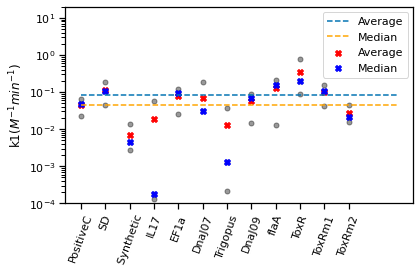

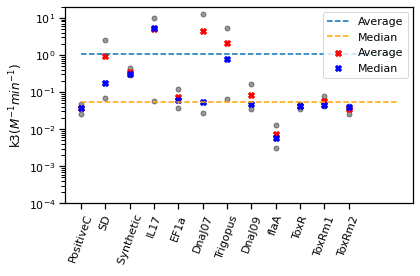

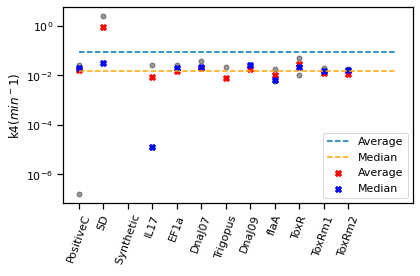

In [109]:
label =['k1','k3','k4']
for j in range(3):
    med = np.median(constants_a.iloc[j])
    counter = 0
    for i in constants_a.columns[:-1]:
        plt.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.4,s=25)
        counter+=1

    plt.xticks(np.arange(0,12,step=1))
    plt.xticks(np.arange(12),n,rotation =70)
    plt.hlines(np.mean(mk[j]),0,13,linestyles='dashed',label='Average')
    plt.hlines(med,0,13,linestyles='dashed',label='Median',color="orange")

    #plt.tight_layout()
    plt.yscale('log')
    if j ==2:
        plt.ylabel('k4($min^-1$)')
    else: 
        plt.ylim(0.0001,20)
        plt.ylabel(label[j] + '($M^{-1}min^{-1}$)')
    plt.scatter([x for x in range(len(mk[j]))],mk[j],color ='red',marker = 'X',label='Average')
    plt.scatter([x for x in range(len(mk[j]))],mek[j],color ='blue',marker = 'X',label="Median")
    plt.legend()
    plt.tight_layout()
    plt.savefig('../images/SHERLOCK/modeling/'+label[j]+ '.png',dpi=300)
    plt.show()

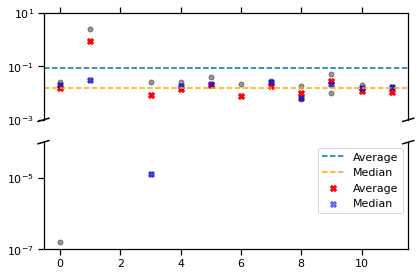

In [118]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
counter = 0
j = 2

for i in constants_a.columns[:-1]:
    ax.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.4,s=25)
    ax2.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.4,s=25)
    
    counter+=1
for a in [ax,ax2]:
    
    a.axhline(np.mean(mk[j]),0,13,linestyle='dashed',label='Average')
    a.axhline(med,0,13,linestyle='dashed',label='Median',color="orange")
    a.scatter([x for x in range(len(mk[j]))],mk[j],color ='red',marker = 'X',label='Average')
    a.scatter([x for x in range(len(mk[j]))],mek[j],color ='blue',marker = 'X',label="Median",alpha=0.5)
    

ax2.set_yscale('log') 
ax.set_yscale('log') 


# zoom-in / limit the view to different portions of the data
ax2.set_ylim(0.0000001, 0.0001)  # outliers only
ax.set_ylim(0.001, 10)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
plt.legend()
plt.tight_layout()
plt.savefig('../images/SHERLOCK/modeling/k4_broken.png',dpi=300)
plt.show()

In [76]:
c = constants_a.loc[:,constants_a.loc['r2'] > 0.85]

c

,PositiveC_1,PositiveC_2,PositiveC_3,SD_1,SD_2,Synthetic DNA_1,Synthetic DNA_2,IL17_1,IL17_3,EF1a_1,...,flaA_3,ToxR_1,ToxR_2,ToxR_3,ToxRm1_1,ToxRm1_2,ToxRm1_3,ToxRm2_1,ToxRm2_2,ToxRm2_3
k1,0.022344,0.065579,4.854148e-02,0.045933,0.186661,0.002679,0.004518,0.056299,0.000183,0.093549,...,0.213681,0.089617,0.763977,0.195672,0.156421,0.042955,0.104943,0.020995,0.045582,0.015190
k3,0.025084,0.046818,3.684793e-02,2.562635,0.067998,0.441385,0.306054,0.055868,5.349370,0.037420,...,0.005863,0.035275,0.046901,0.042535,0.046244,0.078502,0.043041,0.039285,0.025375,0.041715
k4,0.020539,0.026423,1.556580e-07,2.547065,0.030478,0.000000,0.000000,0.025482,0.000000,0.025198,...,0.006717,0.020976,0.010216,0.051024,0.015331,0.000000,0.020320,0.017253,0.000000,0.016531
r2,0.925202,0.900109,9.513673e-01,0.903816,0.954506,0.890154,0.896296,0.946658,0.903549,0.947983,...,0.962530,0.960769,0.953402,0.878585,0.932140,0.917394,0.964102,0.959761,0.984332,0.972737


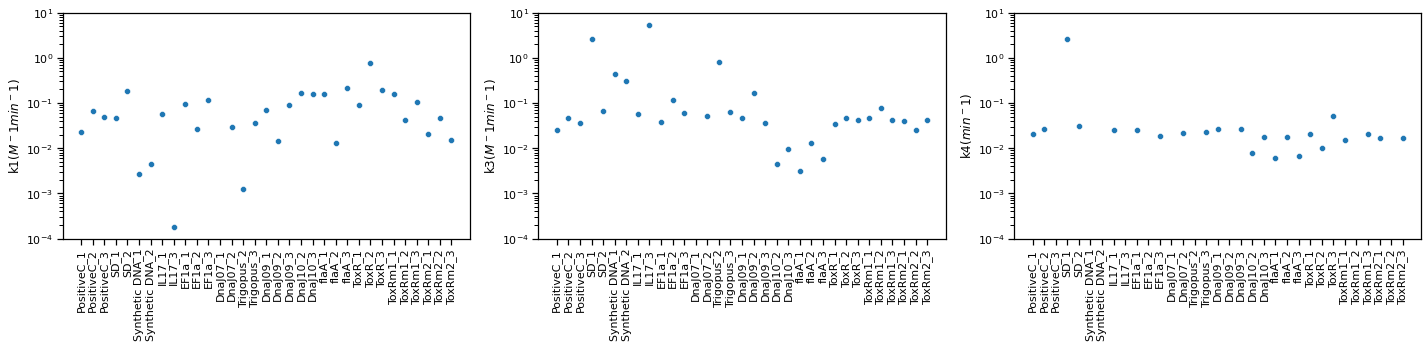

In [98]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

counter = 0

for i in c.index:
    if i == c.index[-1]:
        break
    n = [x for x in c.loc[i].index]
    #print(np.mean(c.loc[i]))
    #print(np.std(c.loc[i]))
    sns.scatterplot([x for x in range(len(c.loc[i]))],c.loc[i],ax =ax[counter])
    
    ax[counter].set_xticks([x for x in range(len(c.loc[i]))])

    ax[counter].set_xticklabels(n,rotation=90)
    ax[counter].set_ylim(0.0001,10)
    ax[counter].set_yscale('log')
    
    
    if i != 'k4':
        ax[counter].set_ylabel(str(i)+'($M^-1min^-1$)')
    else:
        ax[counter].set_ylabel(str(i)+'($min^-1$)')
    counter+=1

plt.tight_layout()
#plt.savefig('../images/SHERLOCK/modeling/distribution_constants.png',dpi=300)
plt.show()
    